In [1]:
import numpy as np

import torch
from torch import nn, optim
import torch.nn.functional as F

import matplotlib.pyplot as plt

torch.set_printoptions(sci_mode = False, precision = 4)

In [19]:
# Hyperparameters
class HParams:
    def __init__(self):
        
        # Problem params
        self.num_agents = 2
        self.num_states = 2
        self.num_signals = 2
        
        self.theta = np.array([0.5, 0.5])
        self.alpha = 2.0
        
        # Minibatch size
        self.batch_size = 128
        
        # Number of samples for computing interim vals
        self.num_samples = 512
        
        # Number of layer
        self.R = 3
        # Number of hidden units
        self.K = 200
        
        # Data - Choose among exp, uniform, asym_uniform, irregular
        self.distr_type = "irregular"
        
        # Opt params
        self.lr = 5e-4
        
        self.gd_lr = 5e-3
        self.gd_iter = 8
        
        # Lagrangian params
        
        self.lag_ob_init = 10
        self.lag_ir_init = 10
        self.lag_ic_init = 10
        
        self.lag_up_iter = 100
        
        self.pho_init = 10
        
        self.pho_increment = 10
        self.pho_up_iter = 100
        
        # Miscellaneous
        self.seed = 0
                  
        self.max_iter = 50000 
        self.print_iter = 1000
                
# Initialize config
cfg = HParams()
np.random.seed(cfg.seed)

# Asserts
assert(cfg.num_agents == 2)
device = "cuda"

np.random.seed(cfg.seed)

In [3]:
def sampler_exp(idx, batch_size):
    return np.random.exponential(scale = 1.0, size = (batch_size))

def sampler_uniform(idx, batch_size):
    return np.random.uniform(low = 0.0, high = 1.0, size = (batch_size))

def sampler_asym_uniform(idx, batch_size):
    return np.random.uniform(low = 0.0, high = idx + 1.0, size = (batch_size))

def sampler_irr(idx, batch_size):    
    sample_1 = np.random.uniform(low = 0.0, high = 3.0, size = (batch_size))
    sample_2 = np.random.uniform(low = 3.0, high = 8.0, size = (batch_size))
    mask = np.random.binomial(1, 0.75, (batch_size))
    return (sample_1 * mask + sample_2 * (1 - mask))/10 

if cfg.distr_type == "exp":
    samplers = sampler_exp

if cfg.distr_type == "uniform":
    samplers = sampler_uniform
        
if cfg.distr_type == "asym_uniform":
    samplers = sampler_asym_uniform
    
if cfg.distr_type == "irregular":
    samplers = sampler_irr

In [4]:
# Utils
def torch_var(x): return torch.Tensor(x).to(device)
def numpy_var(x): return x.detach().cpu().numpy()

# Broadcasting into [n, 1] for easy multiplication
theta = torch_var(cfg.theta)[:, None]

In [5]:
# TODO: Initializations, Softmax temperatures

class PiNet(nn.Module):      
    def __init__(self, cfg):
        super(PiNet, self).__init__()
        self.cfg = cfg
        
        num_agents = self.cfg.num_agents
        num_states = self.cfg.num_states
        num_signals = self.cfg.num_signals
        
        num_layers = self.cfg.R
        num_hidden_nodes = self.cfg.K

        self.pi = nn.ModuleList()
        
        # Input layer
        self.pi.append(nn.Linear(num_agents, num_hidden_nodes))
        self.pi.append(nn.LeakyReLU())
        
        # Hidden layers
        for i in range(num_layers - 1):
            self.pi.append(nn.Linear(num_hidden_nodes, num_hidden_nodes))
            self.pi.append(nn.LeakyReLU())
         
        # Output layer
        self.pi.append(nn.Linear(num_hidden_nodes, num_agents * num_states * num_signals))
        
        for m in self.pi:
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight.data, gain = nn.init.calculate_gain('leaky_relu'))
                nn.init.constant_(m.bias, 0)

        

        
    def forward(self, v):
        out = v
        for module in self.pi: out = module(out)
        out = out.view(-1, self.cfg.num_agents, self.cfg.num_states, self.cfg.num_signals)
        return F.softmax(out, dim = -1)
    
    
class PayNet(nn.Module):     
    def __init__(self, cfg):
        super(PayNet, self).__init__()
        self.cfg = cfg        
        num_layers = self.cfg.R
        num_hidden_nodes = self.cfg.K

        self.pay = nn.ModuleList()
        
        # Input layer
        self.pay.append(nn.Linear(1, num_hidden_nodes))
        self.pay.append(nn.LeakyReLU())
        
        # Hidden layers
        for i in range(num_layers - 1):
            self.pay.append(nn.Linear(num_hidden_nodes, num_hidden_nodes))
            self.pay.append(nn.LeakyReLU())
         
        # Output layer
        self.pay.append(nn.Linear(num_hidden_nodes, 1))
        self.pay.append(nn.Sigmoid())
        
        for m in self.pay:
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight.data, gain = nn.init.calculate_gain('leaky_relu'))
                nn.init.constant_(m.bias, 0)
        
    def forward(self, v):
        out = v[:, None]
        for module in self.pay: out = module(out)
        return out.flatten()

In [6]:
def compute_x_interim(pi_interim):
    """
    Computes interim probability of taking the correct action 
    assuming obedience is satified
    
    Args:
        pi_interim: [Batch_size, Num_States, Num_Signals]
    Returns:
        x_interim: [Batch_size]
    """
    
    return torch.diagonal(pi_interim * theta, offset = 0, dim1 = -2, dim2 = -1).sum(-1)

def compute_x_deviation(pi_interim):
    """
    Computes interim probability of taking the correct action 
    when obedience is not imposed    
    Args:
        pi_interim: [Batch_size, Num_States, Num_Signals]
    Returns:
        x_deviation: [Batch_size]
    """
    
    return torch.max(pi_interim * theta, axis = -2)[0].sum(-1)


def compute_obedience_violations(x_interim, pi_interim):
    """
    Computes obedience violation
    Args:
        x_inteirm: [Batch]
    Returns:
        ob_viol: [Batch]
    """

    x_deviation = compute_x_deviation(pi_interim) 
    ob_viol = F.relu(x_deviation - x_interim)
    return ob_viol

In [7]:
def compute_payments_from_fractions(v_i, payoff_interim, i):
    """
    Computes interim payments from pay_frac
    Args:
        v_i: [Batch]
        payoff_interim: [Batch]
        pay_frac: [Batch]
    Returns:
        payment_interim: [Batch]
    """
    
    # Compute p_frac
    pay_frac = pay_net[i](v_i)
    
    # Payoff if opting out
    payoff_out = max(cfg.theta) - cfg.alpha
    
    """ 
    Pay <= Utility - Utility_out 
         = v_i * (payoff_interim - pay_out)     
    """
    
    payment_interim = v_i * (payoff_interim - payoff_out) * pay_frac
    return payment_interim

In [8]:
def compute_ir_violation(v_i, payoff_interim, pay_interim):
    """
    Computes IR violation
    Args:
        v_i: [Batch]
        payoff_interim: [Batch]
        pay_interim: [Batch]
    Returns:
        ir_viol: [Batch]
    """
    
    # Payoff if opting out
    payoff_out = max(cfg.theta) - cfg.alpha    
    ir_viol = F.relu( v_i * (payoff_out - payoff_interim) + pay_interim )
    return ir_viol

In [9]:
def compute_ic_violation_grid(v_i, payoff_interim, pay_interim):
    """
    Computes IC violation
    Args:
        v_i: [Batch]
        payoff_interim: [Batch]
        pay_interim: [Batch]
    Returns:
        ic_viol: [Batch]
        v_mis: [Batch]

    Compute v - payoff outer-product and subtract payment
    Now we have a utility Mesh u_mesh whose i'th row j'th column has
    the value v[i] * payoff[j] - pay[j]. This is exactly the utility of misreporting with b[i] = v[j]
    The diagonal is the utility of truthful reporting. (as b[i] = v[i])
    Compute ic_violation as max of misreporting - diagonal value.
    
    We can use this to warm-start GD: To be implemented
    """

    u_mesh = v_i[:, None] * payoff_interim[None, :] - pay_interim[None, :]
    
    u_true = torch.diag(u_mesh)
    u_mis, v_mis_idx =  u_mesh.max(axis = -1)
    v_mis = v_i[v_mis_idx]
    
    ic_viol = F.relu(u_mis - u_true)
    return ic_viol, v_mis.detach()

In [10]:
def compute_misreports_gd(v_i, v_mis_i, v_mesh_i, i, gd_lr = 5e-3, gd_iter = 100):
    
    # Autograd variables
    v_mis_i = v_mis_i.detach().clone()
    v_mis_i.requires_grad_(True)
    
    # Optimizer
    opt = torch.optim.Adam([v_mis_i], gd_lr)
    
    for it in range(gd_iter):
        
        opt.zero_grad()        
        u_mis = torch.zeros(cfg.num_agents).to(device)
        
        # Compose misreport - v_mesh [NA, BS, NS, NA]
        v_mesh_mis = torch.cat((v_mesh_i[:, :, :i], v_mis_i[:, None, None].repeat(1, cfg.num_samples, 1), v_mesh_i[:, :, i + 1:]), axis = -1)
        
        pi_mesh_mis = pi_net(v_mesh_mis.view(-1, cfg.num_agents)).view(cfg.batch_size, cfg.num_samples, cfg.num_agents, cfg.num_states, cfg.num_signals)
        pi_interim_mis = pi_mesh_mis.mean(axis = -4)

        #x_interim: [Batch_size, Num_agents], Probability of taking correct actions
        x_interim_all_mis = compute_x_interim(pi_interim_mis) 

        # payoff_interim: x_i - \alpha * \sum_j != i x_j = (1 + \alpha) x_i - (\sum_j) x_j
        payoff_interim_mis = (1 + cfg.alpha) * x_interim_all_mis[:, i] - cfg.alpha * x_interim_all_mis.sum(axis = -1)

        # Compute payments
        pay_interim_mis = compute_payments_from_fractions(v_mis_i, payoff_interim_mis, i)

        u_mis = (v_i * payoff_interim_mis - pay_interim_mis).sum()
            
        u_mis_loss = (-u_mis.sum())
        u_mis_loss.backward(inputs = v_mis_i)
        opt.step()        
        v_mis_i.data.clamp_(min = 0.0)
        
        
    return v_mis_i.detach().clone()

In [11]:
def compute_ic_viol(v_i, payoff_interim, pay_interim, v_mis_i, v_mesh_i, i):
    
    v_mesh_mis = torch.cat((v_mesh_i[:, :, :i], v_mis_i[:, None, None].repeat(1, cfg.num_samples, 1), v_mesh_i[:, :, i + 1:]), axis = -1)
    
    # Compute interim pi_mis
    pi_mesh_mis = pi_net(v_mesh_mis.view(-1, cfg.num_agents)).view(cfg.batch_size, cfg.num_samples, cfg.num_agents, cfg.num_states, cfg.num_signals)
    pi_interim_mis = pi_mesh_mis.mean(axis = -4)
    
    # Compute x_interim_mis, payoff_interim_mis, pay_interim_mis
    x_interim_all_mis = compute_x_interim(pi_interim_mis)
    payoff_interim_mis = (1 + cfg.alpha) * x_interim_all_mis[:, i] - cfg.alpha * x_interim_all_mis.sum(axis = -1)
    pay_interim_mis = compute_payments_from_fractions(v_mis_i, payoff_interim_mis, i)
    
    # Compute u_mis
    u_mis = (v_i * payoff_interim_mis - pay_interim_mis)
    
    # Compute u_true
    u_true = v_i * payoff_interim - pay_interim
    
    # Compute ic_viol
    ic_viol = F.relu(u_mis - u_true)
    return ic_viol

In [12]:
pi_net = PiNet(cfg).to(device)
pay_net = [PayNet(cfg).to(device) for _ in range(cfg.num_agents)]
# Keep in mind that if the distributions are asymetric, we need two different neural networks

In [13]:
lag_ob_init = cfg.lag_ob_init
lag_ir_init = cfg.lag_ir_init
lag_ic_init = cfg.lag_ic_init

pho = cfg.pho_init
pho_increment = cfg.pho_increment

w_ob = torch.ones(cfg.num_agents).to(device) * lag_ob_init
w_ir = torch.ones(cfg.num_agents).to(device) * lag_ir_init
w_ic = torch.ones(cfg.num_agents).to(device) * lag_ic_init

params = []
params.extend(list(pi_net.parameters()))
for i in range(cfg.num_agents):
    params.extend(list(pay_net[i].parameters()))
    
opt = torch.optim.AdamW(params, lr=cfg.lr)

it = 1

In [14]:
"""
V_sample is a tensor of shape [num_agents, batch_size and num_samples].
V_sample[i, :, :] contains 'num_samples' samples of agent i's valuation to be averaged over 
for the computation of interim values of the remaning agents. These samples are the same 
for every valuation profile in the minibatch. (i.e V[i, j, :] = V[i, k, :] )
"""
V_sample = np.zeros((cfg.num_agents, cfg.batch_size, cfg.num_samples))

for i in range(cfg.num_agents):
    V_sample[i] = np.tile(samplers(i, cfg.num_samples)[None, :], (cfg.batch_size, 1))

In [61]:
import time
tic = time.time()
                                  
while it <= cfg.max_iter:
    
    
    opt.zero_grad()
    
    """ 
    Construction of V_mesh:
    V_mesh is of shape [num_agents, batch_size, num_samples, num_agents]
    What's V_mesh[i, j, k, l]?
    V[i, j] - has num_samples elements with the same valuation for agent - i
    but with num_samples values from the V_sample array for other agents
    
    We use this for computation of payment, ic-viol, ob-viol for agent - i only
    """
    
    
    V = np.zeros((cfg.num_agents, cfg.batch_size))
    V_mesh = np.zeros((cfg.num_agents, cfg.batch_size, cfg.num_samples, cfg.num_agents))


    for i in range(cfg.num_agents):
        V[i] = samplers(i, cfg.batch_size) 
        for j in range(cfg.num_agents):
            if i == j:    
                V_mesh[i, :, :, j] = np.tile(V[i][:, None], (1, cfg.num_samples))
            else:
                V_mesh[i, :, :, j] = V_sample[j]
           
    v = torch_var(V)
    v_mesh = torch_var(V_mesh)
    
    
    pi_mesh = pi_net(v_mesh.view(-1, cfg.num_agents)).view(cfg.num_agents, cfg.batch_size, cfg.num_samples, cfg.num_agents, cfg.num_states, cfg.num_signals)   
    pi_mesh = pi_mesh.mean(axis = -4)
        
    revenue = torch.zeros(cfg.num_agents).to(device)
    ob_viol = torch.zeros(cfg.num_agents).to(device)
    ir_viol = torch.zeros(cfg.num_agents).to(device)
    ic_viol = torch.zeros(cfg.num_agents).to(device)
    
    
    
    for i in range(cfg.num_agents):
                
        #pi_interim: [Batch_size, Num_agents, Num_states, Num_signals], experiments assigned
        pi_interim = pi_mesh[i] 
        
        #x_interim: [Batch_size, Num_agents], Probability of taking correct actions
        x_interim_all = compute_x_interim(pi_interim) 
        
        # payoff_interim: x_i - \alpha * \sum_j != i x_j = (1 + \alpha) x_i - (\sum_j) x_j
        payoff_interim = (1 + cfg.alpha) * x_interim_all[:, i] - cfg.alpha * x_interim_all.sum(axis = -1)
        
        # Compute payments
        pay_interim = compute_payments_from_fractions(v[i], payoff_interim, i)
        
        # Compute Revenue        
        revenue[i] = pay_interim.mean()
        
        # Compute obedience violations
        ob_viol[i] = compute_obedience_violations(x_interim_all[:, i], pi_interim[:, i]).mean()
        
        # Compute ir violation
        ir_viol[i] = compute_ir_violation(v[i], payoff_interim, pay_interim).mean()
        
        # Compute ic violation: 
        # Uncomment this for random starts
        # v_mis_init = torch_var(samplers(i,cfg.batch_size))
        
        # Warm-start with the best misreport computed using other minibatch vals
        _, v_mis_init = compute_ic_violation_grid(v[i], payoff_interim, pay_interim)
                
        v_mis = compute_misreports_gd(v[i], v_mis_init, v_mesh[i], i, gd_lr = cfg.gd_lr, gd_iter = cfg.gd_iter)        
        ic_viol[i] = compute_ic_viol(v[i], payoff_interim, pay_interim, v_mis, v_mesh[i], i).mean()
    

    rev_loss = -revenue.sum()
    lagrangian = torch.dot(w_ob, ob_viol) + torch.dot(w_ir, ir_viol) + torch.dot(w_ic, ic_viol)
    penalty = pho * ((ob_viol**2).sum() + (ir_viol**2).sum() + (ic_viol**2).sum())
    
    loss = rev_loss + penalty + lagrangian
    
    loss.backward()   
    opt.step()
    
    if it % cfg.print_iter == 0:
        print("[Iter: %d], [Time Elapsed: %.2fs]"%(it, time.time() - tic))
        print("[Rev: %.4f], [OB Viol: %.4f], [IR Viol: %.4f], [IC Viol: %.4f]"%(revenue.sum(), ob_viol.mean().item(), ir_viol.mean().item(), ic_viol.mean().item()))
        
    if it % cfg.lag_up_iter == 0:
        w_ob.data += pho * ob_viol.data
        w_ic.data += pho * ic_viol.data
        
    if it % cfg.pho_up_iter == 0:
        pho += pho_increment
        
    it += 1

[Iter: 1000], [Time Elapsed: 188.50s]
[Rev: 0.4661], [OB Viol: 0.0000], [IR Viol: 0.0000], [IC Viol: 0.0007]
[Iter: 2000], [Time Elapsed: 385.45s]
[Rev: 0.4343], [OB Viol: 0.0000], [IR Viol: 0.0000], [IC Viol: 0.0006]
[Iter: 3000], [Time Elapsed: 585.44s]
[Rev: 0.4906], [OB Viol: 0.0000], [IR Viol: 0.0000], [IC Viol: 0.0005]
[Iter: 4000], [Time Elapsed: 785.65s]
[Rev: 0.5090], [OB Viol: 0.0000], [IR Viol: 0.0000], [IC Viol: 0.0005]
[Iter: 5000], [Time Elapsed: 985.99s]
[Rev: 0.4150], [OB Viol: 0.0000], [IR Viol: 0.0000], [IC Viol: 0.0006]
[Iter: 6000], [Time Elapsed: 1186.21s]
[Rev: 0.4815], [OB Viol: 0.0000], [IR Viol: 0.0000], [IC Viol: 0.0003]
[Iter: 7000], [Time Elapsed: 1386.32s]
[Rev: 0.4812], [OB Viol: 0.0000], [IR Viol: 0.0000], [IC Viol: 0.0002]
[Iter: 8000], [Time Elapsed: 1586.87s]
[Rev: 0.4118], [OB Viol: 0.0000], [IR Viol: 0.0000], [IC Viol: 0.0002]
[Iter: 9000], [Time Elapsed: 1786.88s]
[Rev: 0.4223], [OB Viol: 0.0000], [IR Viol: 0.0000], [IC Viol: 0.0001]
[Iter: 10000], 

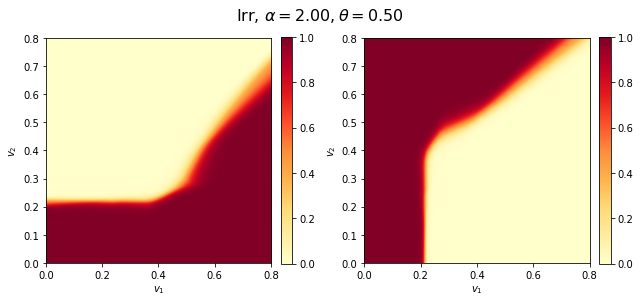

In [25]:
D = 801
v1 = torch_var(np.linspace(0, 0.8, D))
v2 = torch_var(np.linspace(0, 0.8, D))
v_mesh = torch.stack(torch.meshgrid(v1, v2, indexing = "ij"), axis = -1)
pi_mesh = torch.diagonal(pi_net(v_mesh.view(-1, 2)).view(D, D, cfg.num_agents, cfg.num_states, cfg.num_signals) * theta, 0, -2, -1).sum(-1)
AM = numpy_var(pi_mesh)


fig, ax = plt.subplots(ncols = 2, nrows = 1, figsize=(9,4))

img_1 = ax[0].imshow(AM[:, :, 0].transpose(1,0), extent=[0,0.8,0,0.8], vmin = 0.0, vmax=1.0, cmap = 'YlOrRd', origin = "lower")
plt.colorbar(img_1, ax = ax[0], fraction=0.046, pad=0.04)

img_2 = ax[1].imshow(AM[:, :, 1].transpose(1,0), extent=[0,0.8,0,0.8], vmin = 0.0, vmax=1.0, cmap = 'YlOrRd', origin = "lower")
plt.colorbar(img_2, ax = ax[1], fraction=0.046, pad=0.04)

ax[0].set_xlabel("$v_1$")
ax[0].set_ylabel("$v_2$")
ax[1].set_xlabel("$v_1$")
ax[1].set_ylabel("$v_2$")

fig.text(0.5, 1, r"Irr, $\alpha=%.2f, \theta=%.2f$"%(cfg.alpha, max(cfg.theta)), ha='center', size = 16)
fig.tight_layout()

In [ ]:
V = np.linspace(0, 8, 801)
V_mesh = np.stack(np.meshgrid(V, V, indexing = "ij"), axis = -1)

def compute_VV(v):
    vv = np.zeros(v.shape)
    for i in range(v.shape[0]):
        if(v[i] <= (7.0 - np.sqrt(5.0))/2.0):
            vv[i] = 2.0 * v[i] - 4.0
        elif(v[i] <= (11.0 - np.sqrt(5.0))/2.0):
            vv[i] = 3.0 - np.sqrt(5.0)
        else:
            vv[i] = 2.0 * v[i] - 8.0
    return(vv)

VV = compute_VV(V)
VV_mesh = np.stack(np.meshgrid(VV, VV, indexing = "ij"), axis = -1)

In [ ]:
def compute_alloc(V_mesh, VV_mesh):
    x = np.zeros(VV_mesh.shape)
    rev = 0.0
    for i in range(VV_mesh.shape[0]):
        for j in range(VV_mesh.shape[1]):
            x[i, j, 0] =  VV_mesh[i, j, 0] > cfg.alpha * VV_mesh[i, j, 1]
            x[i, j, 1] =  VV_mesh[i, j, 1] > cfg.alpha * VV_mesh[i, j, 0]
            if V_mesh[i, j, 0] <= 2 and V_mesh[i, j, 1] <= 2:
               x[i, j, 0] = 1.0
               x[i, j, 1] = 1.0
            
        rev += x[i, j, 0] * (VV_mesh[i, j, 0] - cfg.alpha * VV_mesh[i, j, 1])
    return x, rev/(VV_mesh.shape[0] * VV_mesh.shape[1])

In [ ]:
X, rev = compute_alloc(V_mesh, VV_mesh)
print(np.shape(X))

(801, 801, 2)


In [24]:
from google.colab import files
# torch.save(pi_net.state_dict(), '5gdirralpha2.pth')
# torch.save(pay_net[0].state_dict(), '5gdirralpha2p1.pth')
# torch.save(pay_net[1].state_dict(), '5gdirralpha2p2.pth')
# # # # download checkpoint file
# files.download('5gdirralpha2.pth')
# files.download('5gdirralpha2p1.pth')
# files.download('5gdirralpha2p2.pth')
# files.upload()
state_dict = torch.load('5gdirralpha2 (1).pth')
state_dict_2 = torch.load('5gdirralpha2p1 (1).pth')
state_dict_3 = torch.load('5gdirralpha2p2 (1).pth')
pi_net.load_state_dict(state_dict)
pay_net[0].load_state_dict(state_dict_2)
pay_net[1].load_state_dict(state_dict_3)

<All keys matched successfully>

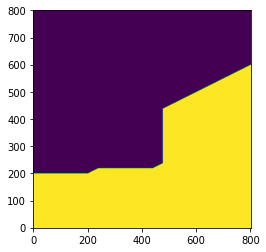

In [ ]:
plt.imshow(X[:, :,0].T, origin = "lower")

In [26]:
import time
import gc
tic = time.time()
                              

""" 
Construction of V_mesh:
V_mesh is of shape [num_agents, batch_size, num_samples, num_agents]
What's V_mesh[i, j, k, l]?
V[i, j] - has num_samples elements with the same valuation for agent - i
but with num_samples values from the V_sample array for other agents

We use this for computation of payment, ic-viol, ob-viol for agent - i only
"""
ctrrev = 0
ctrob = 0
ctrir = 0
ctric = 0
testitr = 5000
for iters in range(testitr):
    opt.zero_grad()
  
    """ 
    Construction of V_mesh:
    V_mesh is of shape [num_agents, batch_size, num_samples, num_agents]
    What's V_mesh[i, j, k, l]?
    V[i, j] - has num_samples elements with the same valuation for agent - i
    but with num_samples values from the V_sample array for other agents
    
    We use this for computation of payment, ic-viol, ob-viol for agent - i only
    """
    
    
    V = np.zeros((cfg.num_agents, cfg.batch_size))
    V_mesh = np.zeros((cfg.num_agents, cfg.batch_size, cfg.num_samples, cfg.num_agents))


    for i in range(cfg.num_agents):
        V[i] = samplers(i, cfg.batch_size)    
        for j in range(cfg.num_agents):
            if i == j:    
                V_mesh[i, :, :, j] = np.tile(V[i][:, None], (1, cfg.num_samples))
            else:
                V_mesh[i, :, :, j] = V_sample[j]
          
    v = torch_var(V)
    v_mesh = torch_var(V_mesh)
    
    
    pi_mesh = pi_net(v_mesh.view(-1, cfg.num_agents)).view(cfg.num_agents, cfg.batch_size, cfg.num_samples, cfg.num_agents, cfg.num_states, cfg.num_signals)   
    pi_mesh = pi_mesh.mean(axis = -4)
        
    revenue = torch.zeros(cfg.num_agents).to(device)
    ob_viol = torch.zeros(cfg.num_agents).to(device)
    ir_viol = torch.zeros(cfg.num_agents).to(device)
    ic_viol = torch.zeros(cfg.num_agents).to(device)
    
    
    
    for i in range(cfg.num_agents):
                
        #pi_interim: [Batch_size, Num_agents, Num_states, Num_signals], experiments assigned
        pi_interim = pi_mesh[i] 
        
        #x_interim: [Batch_size, Num_agents], Probability of taking correct actions
        x_interim_all = compute_x_interim(pi_interim) 
        
        # payoff_interim: x_i - \alpha * \sum_j != i x_j = (1 + \alpha) x_i - (\sum_j) x_j
        payoff_interim = (1 + cfg.alpha) * x_interim_all[:, i] - cfg.alpha * x_interim_all.sum(axis = -1)
        
        # Compute payments
        pay_interim = compute_payments_from_fractions(v[i], payoff_interim, i)
        
        # Compute Revenue        
        revenue[i] = pay_interim.mean()
        
        # Compute obedience violations
        ob_viol[i] = compute_obedience_violations(x_interim_all[:, i], pi_interim[:, i]).mean()
        
        # Compute ir violation
        ir_viol[i] = compute_ir_violation(v[i], payoff_interim, pay_interim).mean()
        
        # Compute ic violation: 
        # Uncomment this for random starts
        # v_mis_init = torch_var(samplers[i](cfg.batch_size))
        
        # Warm-start with the best misreport computed using other minibatch vals
        _, v_mis_init = compute_ic_violation_grid(v[i], payoff_interim, pay_interim)
                
        v_mis = compute_misreports_gd(v[i], v_mis_init, v_mesh[i], i, gd_lr = cfg.gd_lr, gd_iter = cfg.gd_iter)        
        ic_viol[i] = compute_ic_viol(v[i], payoff_interim, pay_interim, v_mis, v_mesh[i], i).mean()
    

    rev_loss = -revenue.sum()
    lagrangian = torch.dot(w_ob, ob_viol) + torch.dot(w_ir, ir_viol) + torch.dot(w_ic, ic_viol)
    penalty = pho * ((ob_viol**2).sum() + (ir_viol**2).sum() + (ic_viol**2).sum())
    
    loss = rev_loss + penalty + lagrangian
    if it % cfg.lag_up_iter == 0:
        w_ob.data += pho * ob_viol.data
        w_ic.data += pho * ic_viol.data
        
    if it % cfg.pho_up_iter == 0:
        pho += pho_increment
        
    it += 1

    ctrrev += revenue.sum()
    ctrob += ob_viol.mean().item()
    ctrir += ir_viol.mean().item()
    ctric += ic_viol.mean().item()
    loss.backward()
    if iters % 1000 == 0 and iters != 0:
      print("[Rev: %.4f], [OB Viol: %.4f], [IR Viol: %.4f], [IC Viol: %.4f]"%(ctrrev/iters, ctrob/iters, ctrir/iters, ctric/iters))

print("[Rev: %.4f], [OB Viol: %.4f], [IR Viol: %.4f], [IC Viol: %.4f]"%(ctrrev/testitr, ctrob/testitr, ctrir/testitr, ctric/testitr))


[Rev: 0.4348], [OB Viol: 0.0000], [IR Viol: 0.0000], [IC Viol: 0.0000]
[Rev: 0.4338], [OB Viol: 0.0000], [IR Viol: 0.0000], [IC Viol: 0.0000]
[Rev: 0.4342], [OB Viol: 0.0000], [IR Viol: 0.0000], [IC Viol: 0.0000]
[Rev: 0.4348], [OB Viol: 0.0000], [IR Viol: 0.0000], [IC Viol: 0.0000]
[Rev: 0.4347], [OB Viol: 0.0000], [IR Viol: 0.0000], [IC Viol: 0.0000]
